In [26]:
import os
import sys
import grid2op
import copy
import numpy as np
import shutil
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from grid2op.Agent import PowerLineSwitch
from grid2op.Reward import L2RPNReward
from grid2op.Runner import Runner
from grid2op.Chronics import GridStateFromFileWithForecasts, Multifolder
path_agents = "study_agent_getting_started"
max_iter = 30

In [27]:
scoring_function = L2RPNReward
env = grid2op.make(reward_class=L2RPNReward, test=True)
# env.chronics_handler.set_max_iter(max_iter)
shutil.rmtree(os.path.abspath(path_agents), ignore_errors=True)
if not os.path.exists(path_agents):
    os.mkdir(path_agents)

# make a runner for this agent
path_agent = os.path.join(path_agents, "PowerLineSwitch")
shutil.rmtree(os.path.abspath(path_agent), ignore_errors=True)

runner = Runner(**env.get_params_for_runner(),
                agentClass=PowerLineSwitch
                )
res = runner.run(path_save=path_agent, nb_episode=2, 
                max_iter=max_iter,
                pbar=tqdm)
print("The results for the evaluated agent are:")
for _, chron_id, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics with id {}\n".format(chron_id)
    msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)



C:\Users\LXM\AppData\Roaming\Python\Python37\site-packages\grid2op\MakeEnv\Make.py:265: UserWarning:

You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.






The results for the evaluated agent are:
	For chronics with id 000
		 - cumulative reward: 497.740265
		 - number of time steps completed: 30 / 30
	For chronics with id 001
		 - cumulative reward: 515.659302
		 - number of time steps completed: 30 / 30


In [28]:
os.listdir(path_agent)


['000',
 '001',
 'dict_action_space.json',
 'dict_attack_space.json',
 'dict_env_modification_space.json',
 'dict_observation_space.json']

In [29]:
from grid2op.Episode import EpisodeData
episode_studied = "001"
this_episode = EpisodeData.from_disk(path_agent, episode_studied)

In [30]:
line_disc = 0
line_reco = 0
line_changed = 0
for act in this_episode.actions:
    dict_ = act.as_dict()
    if "set_line_status" in dict_:
        line_reco += dict_["set_line_status"]["nb_connected"]
        line_disc += dict_["set_line_status"]["nb_disconnected"]
    if "change_line_status" in dict_:
        line_changed += dict_["change_line_status"]["nb_changed"]
print(f'Total lines set to connected : {line_reco}')
print(f'Total lines set to disconnected : {line_disc}')
print(f'Total lines changed: {line_changed}')



Total lines set to connected : 0
Total lines set to disconnected : 0
Total lines changed: 3


In [31]:
id_line_inspected = 13
actions_on_line_14 = 0
for act in this_episode.actions:
    dict_ = act.effect_on(line_id=id_line_inspected) # which effect has this action action on the substation with given id
    # other objects are: load_id, gen_id, line_id or substation_id
    if dict_['change_line_status'] or dict_["set_line_status"] != 0:
        actions_on_line_14 += 1
print(f'Total actions on powerline 14 : {actions_on_line_14}')

Total actions on powerline 14 : 1


In [32]:
nb_hazards = 0
nb_maintenance = 0
for act in this_episode.env_actions:
    dict_ = act.as_dict() # representation of an action as a dictionnary, see the documentation for more information
    if "nb_hazards" in dict_:
        nb_hazards += 1
    if "nb_maintenance" in dict_:
        nb_maintenance += 1
print(f'Total hazards : {nb_hazards}')
print(f'Total maintenances : {nb_maintenance}')



Total hazards : 0
Total maintenances : 0


In [33]:
import plotly.graph_objects as go
load_id = 1
# extract the data
val_load1 = np.zeros(len(this_episode.observations))
for i, obs in enumerate(this_episode.observations):
    dict_ = obs.state_of(load_id=load_id) # which effect has this action action on the substation with id 1
    # other objects are: load_id, gen_id, line_id or substation_id
    # see the documentation for more information.
    val_load1[i] = dict_['p']

# plot it
fig = go.Figure(data=[go.Scatter(x=[i for i in range(len(val_load1))],
                                 y=val_load1)])
fig.update_layout(title="Consumption of load {}".format(load_id),
                 xaxis_title="Time step",
                 yaxis_title="Load (MW)")
fig.show()



In [34]:
gen_id = 4
# extract the data
val_lgen3 = np.zeros(len(this_episode.observations))
for i, obs in enumerate(this_episode.observations):
    dict_ = obs.state_of(gen_id=gen_id) # which effect has this action action on the substation with id 1
    # other objects are: load_id, gen_id, line_id or substation_id
    # see the documentation for more information.
    val_lgen3[i] = dict_['p']

# plot it
fig = go.Figure(data=[go.Scatter(x=[i for i in range(len(val_lgen3))],
                                 y=val_lgen3)])
fig.update_layout(title="Production of generator {}".format(gen_id),
                 xaxis_title="Time step",
                 yaxis_title="Production (MW)")
fig.show()




In [35]:
from_ = 3
to_ = 4
found_ids = this_episode.observations.helper.get_lines_id(from_=from_, to_=to_)
line_id = found_ids[0]

# extract the data
val_l3_4 = np.zeros(len(this_episode.observations))
for i, obs in enumerate(this_episode.observations):
    dict_ = obs.state_of(line_id=line_id) # which effect has this action action on the substation with id 1
    # other objects are: load_id, gen_id, line_id or substation_id
    # see the documentation for more information.
    val_l3_4[i] = dict_["origin"]['a']

# plot it
fig = go.Figure(data=[go.Scatter(x=[i for i in range(len(val_l3_4))],
                                 y=val_l3_4)])
fig.update_layout(title="Flow on powerline {} (going from {} to {})".format(line_id, from_, to_),
                 xaxis_title="Time step",
                 yaxis_title="Production (MW)")
fig.show()


In [36]:
# from grid2op.PlotGrid import PlotMatplot
# obs = copy.deepcopy(this_episode.observations[-1])
# # and change the topology (just to have something to represent)
# obs.topo_vect[3:9] = [2,2,1,1,2,1]
# 
# plot_helper = PlotMatplot(observation_space=this_episode.observation_space, width=900, height=600)
# plot_helper._line_bus_radius = 7
# fig = plot_helper.plot_obs(obs)
# fig.show()


C:\sofeware_install\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



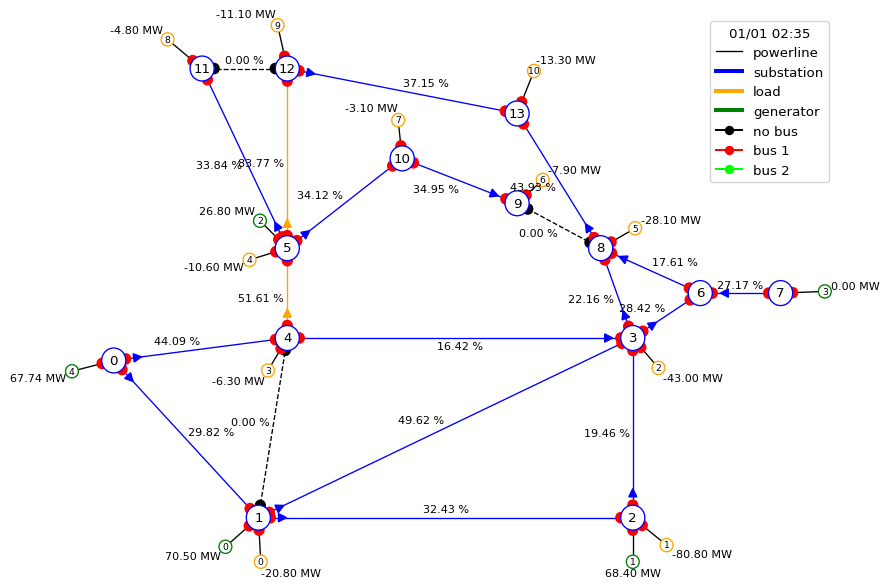

In [37]:

from grid2op.PlotGrid import PlotMatplot
obs = copy.deepcopy(this_episode.observations[-1])
# and change the topology (just to have something to represent)
#obs.topo_vect[3:9] = [2,2,1,1,2,1]

plot_helper = PlotMatplot(observation_space=this_episode.observation_space, width=900, height=600)
plot_helper._line_bus_radius = 7
fig = plot_helper.plot_obs(obs)
fig.show()
